In [1]:
import coniii
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm

Guide to use coniii solvers: https://github.com/eltrompetero/coniii/blob/py3/ipynb/usage_guide.ipynb

In [2]:
def spinize(traces):
    stds = np.std(traces,axis=-1)
    out = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            if traces[i,j]>stds[i]:
                out[i][j] = 1
            else:
                out[i][j] = -1

    return out

    

In [3]:
# import raw trace and transofrm in spins
data = np.load('../../../data/raw_data/nike_calcium_trace.npy')
sample = spinize(data).T
#np.save('../data/processed_data/spins.npy',sample)


In [7]:
# fit model on subset of data
n_neurons = sample.shape[1]
n_timepoints = sample.shape[0]
sub_sample = sample[:n_timepoints,:n_neurons]
solver = coniii.Pseudo(sub_sample)
solver.solve()

/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:125: UserWarning: Assuming that calc_observables should be for Ising model.
  if iprint: warn("Assuming that calc_observables should be for Ising model.")
/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:134: UserWarning: Some pairwise correlations have magnitude close to one. Potential for poor solutions from diverging parameters.
  warn(msg)


array([ 0.03185614,  0.05206406, -0.01979656, ...,  0.06024016,
        0.0162453 ,  0.00349195])

<AxesSubplot:ylabel='Count'>

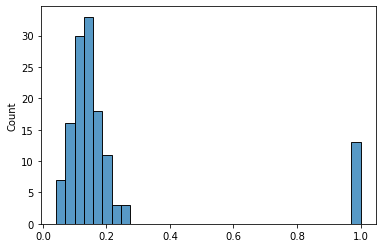

In [9]:
sns.histplot([sum(sample[:,i]==1)/len(sample[:,i]) for i in range(sample.shape[1])])

In [9]:
# unpack fitted value
h,J = solver.multipliers[:n_neurons],solver.multipliers[n_neurons:]

In [13]:
# save data
with open('../../../data/processed_data/pseudo_ll_model.pkl','wb') as f:
    pickle.dump(solver,f)
np.save('../../../data/processed_data/h.npy',h)
np.save('../../../data/processed_data/J.npy',J)

In [14]:
# import data
with open('../../../data/processed_data/pseudo_ll_model.pkl','rb') as f:
    solver = pickle.load(f)

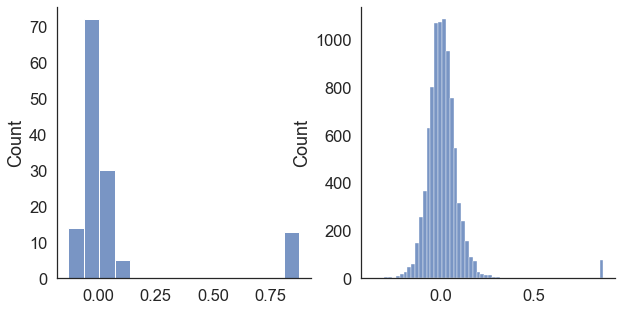

In [16]:
# histograms of values
outlier_th = 1000
n_bins_h = 15
n_bins_J = 60
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5,style='white')
plt.subplot(1,2,1)
sns.histplot(h[np.logical_and(h<outlier_th,h>-outlier_th)],bins=n_bins_h)
sns.despine()
plt.subplot(1,2,2)
sns.histplot(J[np.logical_and(J<outlier_th,J>-outlier_th)],bins=n_bins_J)

sns.despine()

In [17]:
def log_corr(x1,x2):
    a1 = x1==1
    a2 = x2==1
    f1 = sum(a1)/len(a1)
    f2 = sum(a2)/len(a2)
    f12 = sum(a1*a2)/len(a1)
    
    if f1==0 or f2==0:
        out = np.nan
    else:
        out = np.log(f12/(f1*f2))

    return out

In [25]:
CI = []
for i in tqdm(range(n_neurons)):
    for j in range(i+1,n_neurons):
        CI.append(log_corr(sub_sample[:,i],sub_sample[:,j]))

100%|██████████| 134/134 [47:54<00:00, 21.45s/it] 


In [26]:
np.save('../../../data/processed_data/CI.npy',CI)

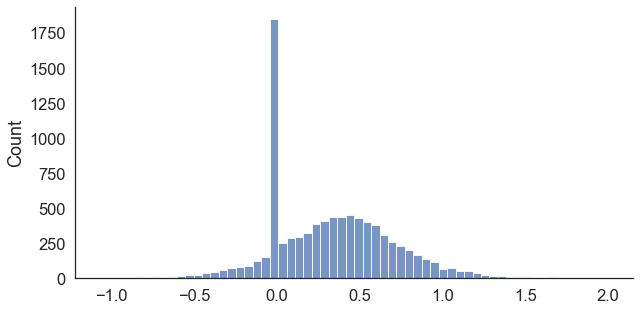

In [27]:
n_bins_CI = 60
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5,style='white')
sns.histplot(CI,bins=n_bins_CI)
sns.despine()

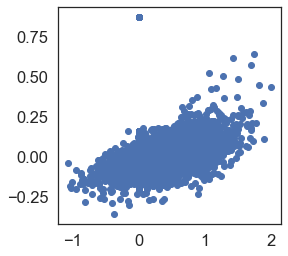

In [32]:
plt.figure(figsize=(4,4))
plt.scatter(CI,J)

In [21]:
len(CI)

8778

In [22]:
len(J)

8911

In [22]:
8911-8788

123

In [23]:
n_neurons

134

In [24]:
n_neurons*(n_neurons-1)/2

8911.0